# Objetivo
En base al conjunto de dataset que disponemos, aprender a analizar la correlacion existente entre los diferentes atributos,para ser capaces de entrenar modelos y realizar predicciones de un atributo en concreto.

# Librerias Usadas


In [19]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import math

# Apartado C

## Cargamos la base de datos

In [20]:
#Obligamos que meutre todas las columnas
pd.set_option('display.max_columns', None)

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('db\\Data_train_reduced.csv')
data = dataset.values

x = data[:, :2]
y = data[:, 2]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (2500, 64)
Dimensionalitat de les entrades X (2500, 2)
Dimensionalitat de l'atribut Y (2500,)


# Entendemos nuestros datos
## Tipo de datos

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 64 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Respondent.ID                                            2500 non-null   int64  
 1   Product.ID                                               2500 non-null   int64  
 2   Product                                                  2500 non-null   object 
 3   Instant.Liking                                           2500 non-null   int64  
 4   q1_1.personal.opinion.of.this.Deodorant                  2500 non-null   int64  
 5   q2_all.words                                             2500 non-null   int64  
 6   q3_1.strength.of.the.Deodorant                           2500 non-null   int64  
 7   q4_1.artificial.chemical                                 2500 non-null   int64  
 8   q4_2.attractive             

## Buscamos si tenemos datos nulos
Como podemos observar no tenemos ninguna perdida de datos

In [22]:
dataset.isnull().sum()

Respondent.ID                                     0
Product.ID                                        0
Product                                           0
Instant.Liking                                    0
q1_1.personal.opinion.of.this.Deodorant           0
                                                 ..
s11.marital.status                                0
s12.working.status                                0
s13.2                                             0
s13a.b.most.often                                 0
s13b.bottles.of.Deodorant.do.you.currently.own    0
Length: 64, dtype: int64

Para tener un mejor punto de vista de los valores nulos, crearemos una grafica donde nos lo indique visualmente

<AxesSubplot:>

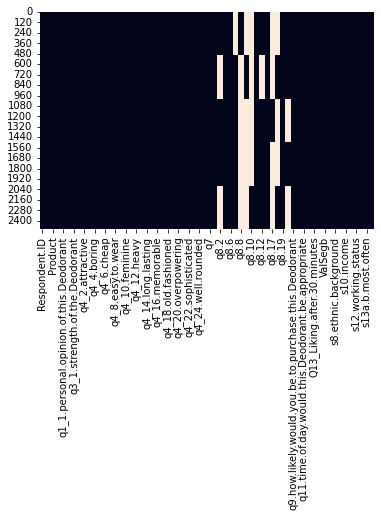

In [23]:
sns.heatmap(dataset.isnull(), cbar=False)

Eliminamos los valores nulos

In [24]:
dataset.dropna(1)

C:\Users\LUISFE~1\AppData\Local\Temp/ipykernel_10928/1434505788.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  dataset.dropna(1)


,Respondent.ID,Product.ID,Product,Instant.Liking,q1_1.personal.opinion.of.this.Deodorant,q2_all.words,q3_1.strength.of.the.Deodorant,q4_1.artificial.chemical,q4_2.attractive,q4_3.bold,q4_4.boring,q4_5.casual,q4_6.cheap,q4_7.clean,q4_8.easy.to.wear,q4_9.elegant,q4_10.feminine,q4_11.for.someone.like.me,q4_12.heavy,q4_13.high.quality,q4_14.long.lasting,q4_15.masculine,q4_16.memorable,q4_17.natural,q4_18.old.fashioned,q4_19.ordinary,q4_20.overpowering,q4_21.sharp,q4_22.sophisticated,q4_23.upscale,q4_24.well.rounded,q5_1.Deodorant.is.addictive,q7,q8.1,q8.5,q8.6,q8.11,q8.13,q8.19,q9.how.likely.would.you.be.to.purchase.this.Deodorant,q10.prefer.this.Deodorant.or.your.usual.Deodorant,q11.time.of.day.would.this.Deodorant.be.appropriate,q12.which.occasions.would.this.Deodorant.be.appropriate,Q13_Liking.after.30.minutes,q14.Deodorant.overall.on.a.scale.from.1.to.10,ValSegb,s7.involved.in.the.selection.of.the.cosmetic.products,s8.ethnic.background,s9.education,s10.income,s11.marital.status,s12.working.status,s13.2,s13a.b.most.often,s13b.bottles.of.Deodorant.do.you.currently.own
0,3800,121,Deodorant B,1,4,1,4,2,5,4,2,3,5,5,5,4,5,3,1,5,1,2,4,5,4,5,1,1,4,1,4,1,1,0,0,0,0,0,0,2,1,1,2,1,7,7,4,1,4,3,1,1,0.000,0,3
1,3801,121,Deodorant B,0,5,1,4,4,2,2,1,3,2,4,4,4,3,1,1,3,4,4,5,3,3,4,2,2,5,4,4,4,4,0,0,1,0,0,0,3,5,3,3,3,8,6,4,1,4,3,1,1,0.000,0,4
2,3802,121,Deodorant B,0,6,1,3,2,5,2,4,2,4,3,5,4,4,4,3,1,2,1,4,2,4,3,2,5,4,4,3,4,3,0,0,0,0,0,0,5,1,3,3,2,5,7,4,1,3,5,1,1,0.000,0,2
3,3803,121,Deodorant B,1,4,0,4,5,5,4,3,5,2,5,3,5,5,5,1,4,3,3,5,5,4,2,5,3,3,5,4,4,3,0,0,0,0,0,0,5,4,1,3,6,8,1,4,1,4,9,1,3,0.000,0,3
4,3804,121,Deodorant B,1,4,1,2,1,3,1,1,3,3,5,3,5,5,5,1,4,4,2,3,5,1,2,4,2,3,1,5,3,2,0,0,0,0,0,0,5,3,3,2,5,4,4,4,1,3,5,1,2,0.000,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,5695,230,Deodorant J,0,6,1,3,4,5,4,5,3,3,3,5,5,4,3,5,4,5,1,5,1,1,1,2,5,4,2,5,3,0,0,0,0,0,0,0,4,1,3,2,7,10,6,4,4,3,4,2,6,0.000,0,3
2496,5696,230,Deodorant J,0,5,0,3,1,4,1,5,2,1,5,4,5,4,4,3,3,2,1,4,5,5,3,2,3,2,4,1,4,0,0,0,0,0,1,0,4,3,3,3,7,6,3,4,1,2,9,2,1,0.000,0,2
2497,5697,230,Deodorant J,1,4,2,3,3,5,4,1,3,1,3,1,5,5,1,3,5,4,1,4,3,4,5,1,5,4,5,4,5,3,0,0,0,0,0,0,2,1,1,3,6,3,7,4,5,4,6,1,1,0.000,0,5
2498,5698,230,Deodorant J,0,5,2,4,2,3,4,1,2,5,3,5,3,4,5,5,5,5,1,3,2,2,5,2,3,5,3,3,3,3,0,0,0,0,0,0,2,3,3,3,1,7,2,4,1,3,5,3,2,0.000,0,4


Observamos que la dimension de nuestro dataset ha pasado de ser 64 a 55

## Estadisticas de los datos

In [25]:
dataset.describe()

,Respondent.ID,Product.ID,Instant.Liking,q1_1.personal.opinion.of.this.Deodorant,q2_all.words,q3_1.strength.of.the.Deodorant,q4_1.artificial.chemical,q4_2.attractive,q4_3.bold,q4_4.boring,q4_5.casual,q4_6.cheap,q4_7.clean,q4_8.easy.to.wear,q4_9.elegant,q4_10.feminine,q4_11.for.someone.like.me,q4_12.heavy,q4_13.high.quality,q4_14.long.lasting,q4_15.masculine,q4_16.memorable,q4_17.natural,q4_18.old.fashioned,q4_19.ordinary,q4_20.overpowering,q4_21.sharp,q4_22.sophisticated,q4_23.upscale,q4_24.well.rounded,q5_1.Deodorant.is.addictive,q7,q8.1,q8.2,q8.5,q8.6,q8.7,q8.8,q8.9,q8.10,q8.11,q8.12,q8.13,q8.17,q8.18,q8.19,q8.20,q9.how.likely.would.you.be.to.purchase.this.Deodorant,q10.prefer.this.Deodorant.or.your.usual.Deodorant,q11.time.of.day.would.this.Deodorant.be.appropriate,q12.which.occasions.would.this.Deodorant.be.appropriate,Q13_Liking.after.30.minutes,q14.Deodorant.overall.on.a.scale.from.1.to.10,ValSegb,s7.involved.in.the.selection.of.the.cosmetic.products,s8.ethnic.background,s9.education,s10.income,s11.marital.status,s12.working.status,s13.2,s13a.b.most.often,s13b.bottles.of.Deodorant.do.you.currently.own
count,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,1500.000,2500.000,2500.000,2000.000,500.000,500.000,500.000,2500.000,2000.000,2500.000,500.000,1000.000,2500.000,1500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000
mean,8249.500,460.400,0.247,5.130,1.121,3.344,2.500,3.717,3.546,2.242,3.487,2.348,3.789,3.751,3.628,4.016,3.558,2.809,3.683,4.003,2.078,3.826,3.467,2.629,2.860,2.979,3.332,3.635,3.528,3.648,3.336,1.400,0.047,0.064,0.053,0.049,0.042,0.112,0.078,0.114,0.021,0.062,0.038,0.106,0.061,0.005,0.053,3.590,2.826,2.318,2.195,4.960,6.747,3.522,4.000,1.665,3.199,4.996,1.742,1.898,0.025,0.038,3.072
std,3433.009,308.413,0.431,1.482,0.934,0.743,1.385,1.275,1.262,1.243,1.277,1.312,1.209,1.306,1.260,1.200,1.368,1.474,1.220,1.102,1.272,1.164,1.278,1.409,1.301,1.426,1.307,1.271,1.281,1.197,1.319,1.265,0.212,0.245,0.224,0.215,0.199,0.316,0.268,0.318,0.143,0.242,0.192,0.308,0.239,0.072,0.223,1.397,1.398,0.805,0.849,1.769,2.505,1.964,0.000,1.037,0.970,2.371,0.727,1.440,0.105,0.192,1.620
min,3800.000,121.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,4.000,1.000,2.000,2.000,1.000,1.000,0.000,0.000,1.000
25%,5324.750,230.000,0.000,5.000,0.000,3.000,1.000,3.000,3.000,1.000,3.000,1.000,3.000,3.000,3.000,4.000,3.000,1.000,3.000,3.000,1.000,3.000,3.000,1.000,2.000,2.000,2.000,3.000,3.000,3.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,2.000,2.000,1.000,4.000,5.000,2.000,4.000,1.000,2.000,3.000,1.000,1.000,0.000,0.000,2.000
50%,8249.500,344.000,0.000,5.000,1.000,3.000,2.000,4.000,4.000,2.000,4.000,2.000,4.000,4.000,4.000,4.000,4.000,3.000,4.000,4.000,2.000,4.000,4.000,2.000,3.000,3.000,4.000,4.000,4.000,4.000,4.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,3.000,3.000,2.000,5.000,7.000,3.000,4.000,1.000,3.000,4.000,2.000,1.000,0.000,0.000,3.000
75%,9774.250,633.000,0.000,6.000,2.000,4.000,4.000,5.000,5.000,3.000,5.000,3.000,5.000,5.000,5.000,5.000,5.000,4.000,5.000,5.000,3.000,5.000,5.000,4.000,4.000,4.000,4.000,5.000,5.000,5.000,4.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,4.000,3.000,3.000,6.000,9.000,5.000,4.000,2.000,4.000,7.000,2.000,2.000,

## Los atributos

In [26]:
dataset.keys()

Index(['Respondent.ID', 'Product.ID', 'Product', 'Instant.Liking',
       'q1_1.personal.opinion.of.this.Deodorant', 'q2_all.words',
       'q3_1.strength.of.the.Deodorant', 'q4_1.artificial.chemical',
       'q4_2.attractive', 'q4_3.bold', 'q4_4.boring', 'q4_5.casual',
       'q4_6.cheap', 'q4_7.clean', 'q4_8.easy.to.wear', 'q4_9.elegant',
       'q4_10.feminine', 'q4_11.for.someone.like.me', 'q4_12.heavy',
       'q4_13.high.quality', 'q4_14.long.lasting', 'q4_15.masculine',
       'q4_16.memorable', 'q4_17.natural', 'q4_18.old.fashioned',
       'q4_19.ordinary', 'q4_20.overpowering', 'q4_21.sharp',
       'q4_22.sophisticated', 'q4_23.upscale', 'q4_24.well.rounded',
       'q5_1.Deodorant.is.addictive', 'q7', 'q8.1', 'q8.2', 'q8.5', 'q8.6',
       'q8.7', 'q8.8', 'q8.9', 'q8.10', 'q8.11', 'q8.12', 'q8.13', 'q8.17',
       'q8.18', 'q8.19', 'q8.20',
       'q9.how.likely.would.you.be.to.purchase.this.Deodorant',
       'q10.prefer.this.Deodorant.or.your.usual.Deodorant',
       'q11

## Mostramos los 5 priemros datos

In [27]:
dataset.head()

,Respondent.ID,Product.ID,Product,Instant.Liking,q1_1.personal.opinion.of.this.Deodorant,q2_all.words,q3_1.strength.of.the.Deodorant,q4_1.artificial.chemical,q4_2.attractive,q4_3.bold,q4_4.boring,q4_5.casual,q4_6.cheap,q4_7.clean,q4_8.easy.to.wear,q4_9.elegant,q4_10.feminine,q4_11.for.someone.like.me,q4_12.heavy,q4_13.high.quality,q4_14.long.lasting,q4_15.masculine,q4_16.memorable,q4_17.natural,q4_18.old.fashioned,q4_19.ordinary,q4_20.overpowering,q4_21.sharp,q4_22.sophisticated,q4_23.upscale,q4_24.well.rounded,q5_1.Deodorant.is.addictive,q7,q8.1,q8.2,q8.5,q8.6,q8.7,q8.8,q8.9,q8.10,q8.11,q8.12,q8.13,q8.17,q8.18,q8.19,q8.20,q9.how.likely.would.you.be.to.purchase.this.Deodorant,q10.prefer.this.Deodorant.or.your.usual.Deodorant,q11.time.of.day.would.this.Deodorant.be.appropriate,q12.which.occasions.would.this.Deodorant.be.appropriate,Q13_Liking.after.30.minutes,q14.Deodorant.overall.on.a.scale.from.1.to.10,ValSegb,s7.involved.in.the.selection.of.the.cosmetic.products,s8.ethnic.background,s9.education,s10.income,s11.marital.status,s12.working.status,s13.2,s13a.b.most.often,s13b.bottles.of.Deodorant.do.you.currently.own
0,3800,121,Deodorant B,1,4,1,4,2,5,4,2,3,5,5,5,4,5,3,1,5,1,2,4,5,4,5,1,1,4,1,4,1,1,0,0.000,0,0,NaN,1.000,NaN,NaN,0,0.000,0,NaN,NaN,0,0.000,2,1,1,2,1,7,7,4,1,4,3,1,1,0.000,0,3
1,3801,121,Deodorant B,0,5,1,4,4,2,2,1,3,2,4,4,4,3,1,1,3,4,4,5,3,3,4,2,2,5,4,4,4,4,0,0.000,0,1,NaN,0.000,NaN,NaN,0,0.000,0,NaN,NaN,0,0.000,3,5,3,3,3,8,6,4,1,4,3,1,1,0.000,0,4
2,3802,121,Deodorant B,0,6,1,3,2,5,2,4,2,4,3,5,4,4,4,3,1,2,1,4,2,4,3,2,5,4,4,3,4,3,0,0.000,0,0,NaN,0.000,NaN,NaN,0,0.000,0,NaN,NaN,0,0.000,5,1,3,3,2,5,7,4,1,3,5,1,1,0.000,0,2
3,3803,121,Deodorant B,1,4,0,4,5,5,4,3,5,2,5,3,5,5,5,1,4,3,3,5,5,4,2,5,3,3,5,4,4,3,0,0.000,0,0,NaN,0.000,NaN,NaN,0,0.000,0,NaN,NaN,0,0.000,5,4,1,3,6,8,1,4,1,4,9,1,3,0.000,0,3
4,3804,121,Deodorant B,1,4,1,2,1,3,1,1,3,3,5,3,5,5,5,1,4,4,2,3,5,1,2,4,2,3,1,5,3,2,0,0.000,0,0,NaN,0.000,NaN,NaN,0,0.000,0,NaN,NaN,0,0.000,5,3,3,2,5,4,4,4,1,3,5,1,2,0.000,0,3


Entendemos que tipo de producto tenemos

In [28]:
print(dataset['Product'].value_counts())
print("Total = ", len(dataset))

Deodorant B    500
Deodorant F    500
Deodorant G    500
Deodorant H    500
Deodorant J    500
Name: Product, dtype: int64
Total =  2500


## Mostrar datos

Mostramos la media de valoracion que tiene cada producto (no tiene porque ser mejor el mayor, ya que hay preguntas negativas)

C:\Users\LUISFE~1\AppData\Local\Temp/ipykernel_10928/2622846732.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset['mean']=(dataset.mean(axis=1)/(dataset.shape[1]-3))


<BarContainer object of 2500 artists>

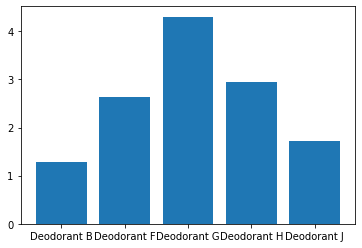

In [29]:
dataset['mean']=(dataset.mean(axis=1)/(dataset.shape[1]-3))
plt.bar(dataset['Product'],dataset['mean'])

Miramos si existe alguna correlación entre los atributos, nuestra lógica dice que entre los atributos instan_liking y personal_opinion debe de haber alguna relación

<AxesSubplot:>

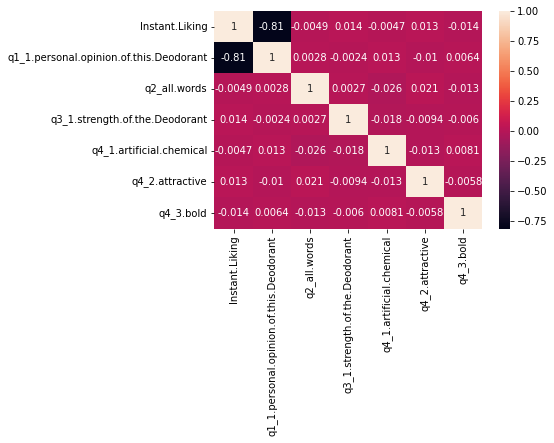

In [30]:
correlacio = dataset.iloc[:,3:10].corr()

fig , ax = plt.subplots()
sns.heatmap(correlacio,annot=True)

Creamos graficas de todos los atributos

array([[<AxesSubplot:title={'center':'Respondent.ID'}>,
        <AxesSubplot:title={'center':'Product.ID'}>,
        <AxesSubplot:title={'center':'Instant.Liking'}>,
        <AxesSubplot:title={'center':'q1_1.personal.opinion.of.this.Deodorant'}>,
        <AxesSubplot:title={'center':'q2_all.words'}>,
        <AxesSubplot:title={'center':'q3_1.strength.of.the.Deodorant'}>,
        <AxesSubplot:title={'center':'q4_1.artificial.chemical'}>,
        <AxesSubplot:title={'center':'q4_2.attractive'}>],
       [<AxesSubplot:title={'center':'q4_3.bold'}>,
        <AxesSubplot:title={'center':'q4_4.boring'}>,
        <AxesSubplot:title={'center':'q4_5.casual'}>,
        <AxesSubplot:title={'center':'q4_6.cheap'}>,
        <AxesSubplot:title={'center':'q4_7.clean'}>,
        <AxesSubplot:title={'center':'q4_8.easy.to.wear'}>,
        <AxesSubplot:title={'center':'q4_9.elegant'}>,
        <AxesSubplot:title={'center':'q4_10.feminine'}>],
       [<AxesSubplot:title={'center':'q4_11.for.someone.lik

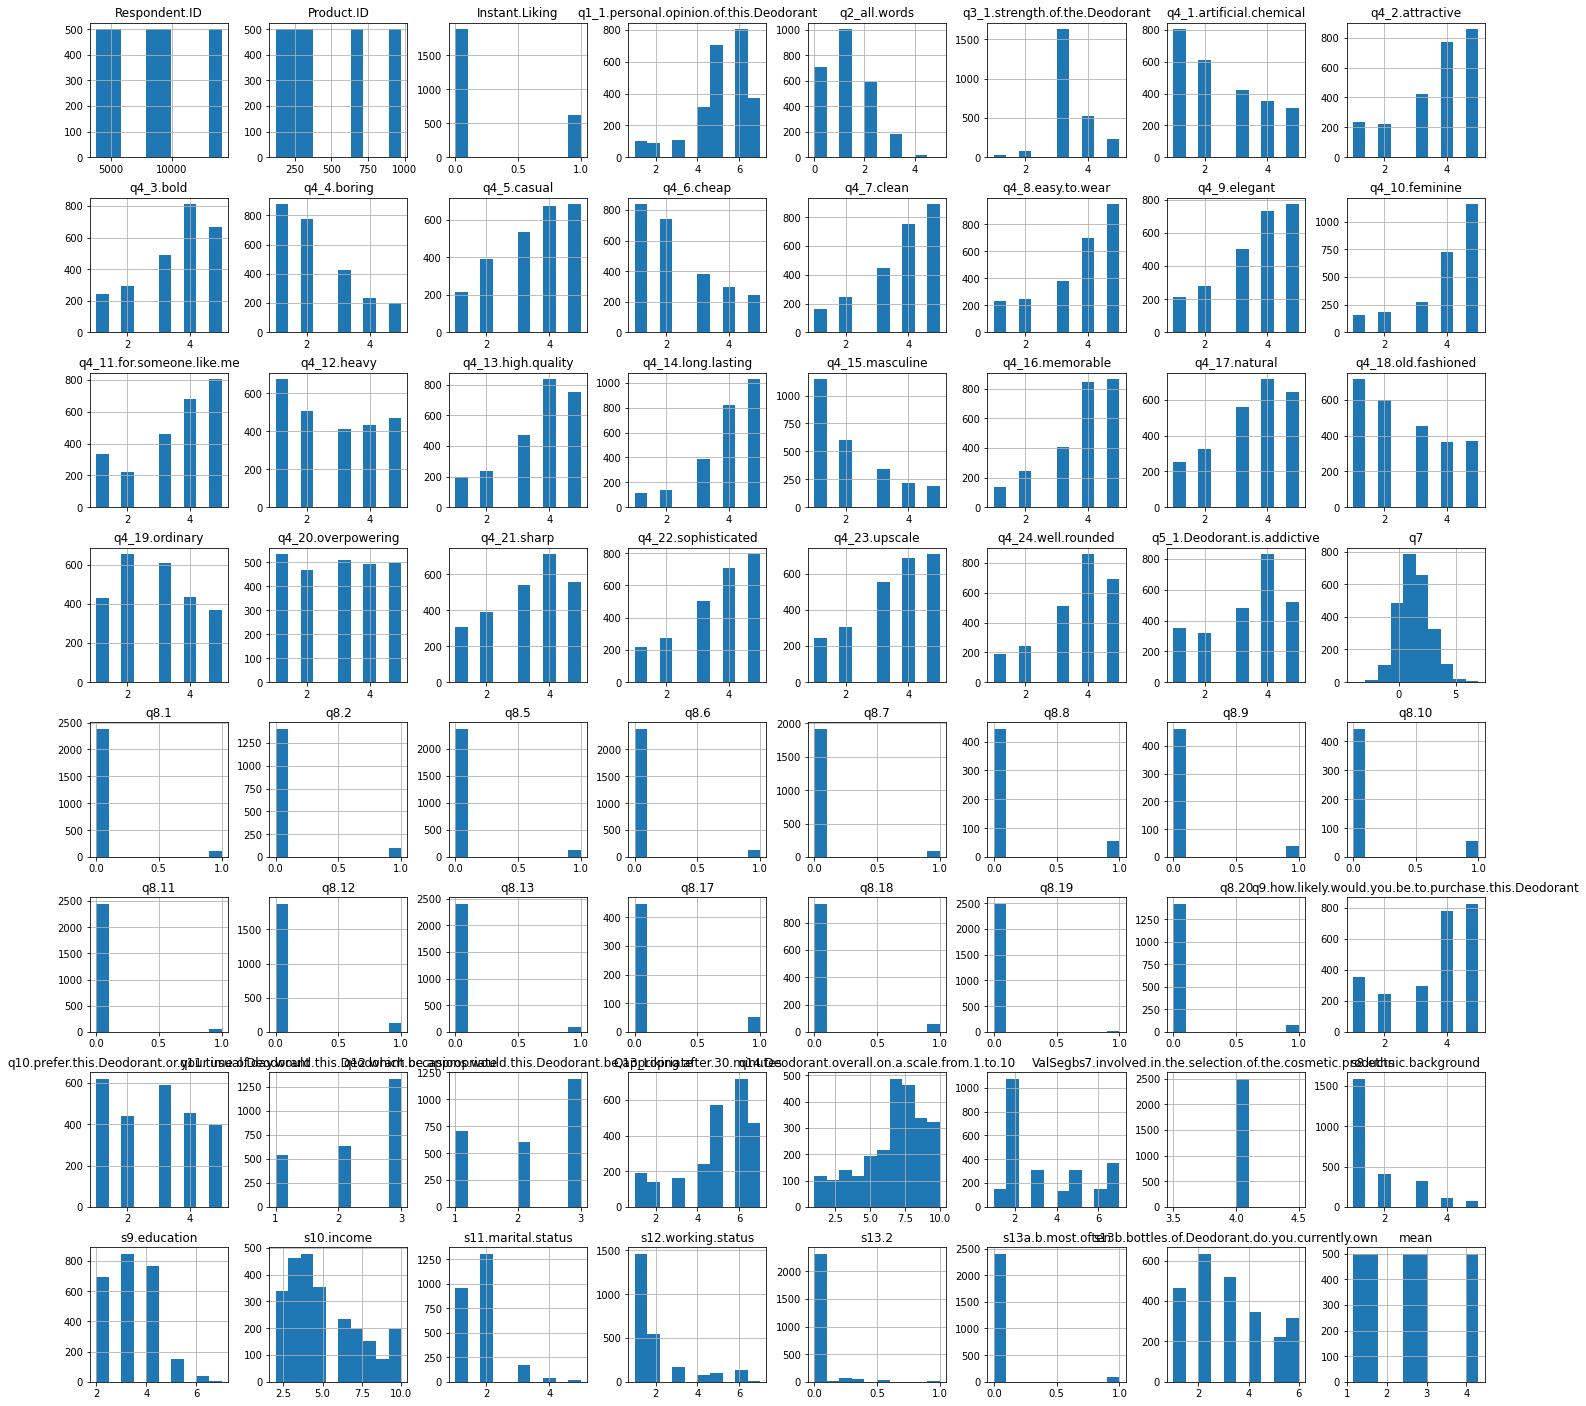

In [31]:
dataset.hist(figsize=(25,25))

## Preguntas
### ¿Cuál es el tipo de cada atributo?

Para determinar el tipo de atributo, podemos hacer uso de la funcion dataset.info() que nos muestra el tipo de valor de cada uno de los elementos de los que esta compuesto nuestro dataset.
Por ejemplo en nuestro caso, al ejecutar dicho comando nos devuelve una lista de cada una de las columnas, y al final del todo nos proporciona la siguiente informacion:
dtypes: float64(10), int64(53), object(1)

### ¿Qué atributos tienen una distribución Guassiana?
En nuestro caso para poder determinar que atributo tenia dicha distribucion, hemos hecho uso de la comanda dataset.hist(figsize=(20,20)), esto nos devuelve un histograma para cada uno de los atributos del dataset, y hemos identificado que el atributo q7 y la media tienen una distribucion Guassiana.

### ¿Cuál es el atributo objetivo? ¿Por qué?
Despues del analisis de los datos que disponemos, llegamos a la conclusion que lo ideal seria predecir el tipo de producto en base al conjunto de 'Xs' de entrada, ya que en este caso disponemos de un sin numero de entradas con valores calificativos de diferentes caracteristicas del producto.

# Apartado B